In [0]:
from scipy.integrate import odeint
import matplotlib.pylab as plt
from math import log,exp
import numpy as np

In [0]:
def volume(BW,Age,h):
    #unit is L;  BW,kg; h,meter; Age,years.
    BSA = 0.007184*BW**0.425*h**0.725
    BMI = BW/(h*h)
    Liver_cells = exp(1.98*log(h)-0.6786)/1.03
    
    result = {'Adipose':(BW*((1.2*BMI+0.23*Age-10.8*0-5.4)/100))/0.916, 'Arterial':0.33*4/1.025,
              'Venous':0.67*4/1.025, 'Bone': exp(2.67*log(h)+0.0689)/1.99,
              'Brain': (0.373*( (3.68-2.68*exp((-Age)/0.89) )*(exp((-Age)/629) ) ))/1.035,
              'Gonads': (3.3+90*(1-exp(-(Age/16.8)**6.7 ) ))/(1000*1.03), 'Heart': exp(2.13*log(h)-2.502)/1.03,
              'Intestine': exp(2.47*log(h)-1.351)/1.042 ,'Kidney':exp(1.93*log(h)-2.306)/1.05, 'Liver_blood':Liver_cells*0.075,
                'Liver_cells':Liver_cells ,'Lung':exp(2.1*log(h)-2.092)/1.05, 'Pancreas':exp(2.43*log(h)-3.431)/1.045,
              'Rest':exp(1.0*log(h)-0.072)/1.03, 'Skin': exp(2.63*log(h)-1.93)/1.5 , 'Spleen': exp(2.16*log(h)-3.123)/1.054 ,                                   'Stomach': exp(2.45*log(h)-3.266)/1.44 , 
              'Thymus': (14*(  (7.1-6.1*exp((-Age)/11.9) )*(0.14+0.86*exp((-Age)/10.3) )  ) )/(1000*1.03)  }
                
    v_sum = 0
    for n in result.keys():
        v_sum = v_sum + result[ n ]
        
    result['Muscle'] = (BW*0.93- v_sum )/1.041
    
    return result

In [0]:
def flow( vol ):
    #Organ Blood Flow (L/hours)
    Q1=  vol['Adipose']*1.4*0.916*0.55  #adipose
    Q2=  vol['Bone']*1.8*1.99*0.55#bone
    Q3=  vol['Brain']*32.7*1.035*0.55#brain
    Q4=  vol['Gonads']*0.8*1.03*0.55 #gonads
    Q5=  vol['Heart']*70.8*1.03*0.55#heart
    Q6=  vol['Intestine']*59.0*1.042*0.55 #intestine
    Q7=  vol['Kidney']*215*1.05*0.55#kidney
    Q8=  vol['Liver_cells']*16.4*1.03*0.55#liver(arterial)
    Q11= vol['Muscle']*2.4*1.041*0.55 #muscle
    Q12= vol['Pancreas']*29.5*1.045*0.55 #pancreas
    Q13= vol['Rest']*18.8*1.03*0.55 #rest of body
    Q14= vol['Skin']*7.7*1.5*0.55 #skin
    Q15= vol['Spleen']*81.5*1.054*0.55 #spleen
    Q16= vol['Stomach']*25.3*1.044*0.55 #stomach
    Q17= vol['Thymus']*18.5*1.03*0.55 #thymus
    Q9 = Q8+Q6+Q12+Q15+Q16 #liver(venous)
    CO = Q1+Q2+Q3+Q4+Q5+Q6+Q7+Q9+Q11+Q12+Q13+Q14+Q15+Q16+Q17#cardiac output
    Q10 = CO #lung

    result = {'Adipose':Q1,'Bone':Q2,'Brain':Q3,'Gonads':Q4 ,'Heart':Q5 ,'Intestine':Q6 ,'Kidney':Q7 ,
              'Liver_arterial':Q8, 'Liver_venous': Q9 , 'Lung':Q10 , 'Muscle':Q11 ,'Pancreas':Q12 ,'Rest':Q13 ,'Skin':Q14 ,
                'Spleen':Q15 ,'Stomach':Q16 , 'Thymus': Q17, 'CO':CO }
    
    return result

In [0]:
def func(y, t):
    BW= 60
    Age = 25
    h = 1.65
    vol = volume(BW,Age,h) # volume of each compartment(dict)
    Q = flow( vol )#blood flow(dict)
    k_IV_infusion = 0
        #initial conditions, named as "molecule_organ""
    ( E2_venous,SHBG_venous,E2SHBG_venous,Albumin_venous,E2Albumin_venous,E2_arterial,SHBG_arterial,
        E2SHBG_arterial,Albumin_arterial,E2Albumin_arterial,E2_Adipose,E2_Bone,E2_Brain,E2_Gonads_blood,
        E2_Gonads_cells,ER_Gonads_cells,E2ER_Gonads_cells,E2_Heart,E2_Intestine,E2_Kidney,E2_Liver_blood,
        E2_Liver_cells,ER_Liver_cells,E2ER_Liver_cells,E2_Lung,E2_Muscle,E2_Pancreas,E2_Rest,E2_Skin,E2_Spleen,
        E2_Stomach,E2_Thymus,E2_Dose_oral,E2_Dose_IV ) = y #34 variables
        
        #E2: estradiol;  SHBG: sex hormone binding globulin; ER:estrogen receptor  E2Albumin or E2SHBG means bound together;
        #unit of reaction rate is nM/h

    E2_venous_dt = (  Q['Adipose']*E2_Adipose + Q['Bone']*E2_Bone + Q['Brain']* E2_Brain + E2_Dose_IV*250  + k_IV_infusion
                        + Q['Gonads']*E2_Gonads_blood + Q['Heart']*E2_Heart + Q['Kidney']*E2_Kidney
                        + Q['Liver_venous']*E2_Liver_blood + Q['Muscle']*E2_Muscle + Q['Rest']*E2_Rest + Q['Skin']*E2_Skin 
                        + Q['Thymus']*E2_Thymus - E2_venous*Q['Lung'] 
                        - (E2_venous*Albumin_venous*3600  - E2Albumin_venous*6.12e+7) 
                        - (E2_venous*SHBG_venous*3600 -E2SHBG_venous*5400))
                        
    SHBG_venous_dt = - (E2_venous*SHBG_venous*3600 -E2SHBG_venous*5400) 
    E2SHBG_venous_dt =  E2_venous*SHBG_venous*3600 -E2SHBG_venous*5400  
    Albumin_venous_dt =  - (E2_venous*Albumin_venous*3600  - E2Albumin_venous*6.12e+7) 
    E2Albumin_venous_dt = E2_venous*Albumin_venous*3600  - E2Albumin_venous*6.12e+7  
        
    E2_arterial_dt =(  Q['Lung']*E2_Lung - E2_arterial*Q['Adipose'] - (E2_arterial*Albumin_arterial*3600 - E2Albumin_arterial*6.12e+7) 
                        - (E2_arterial*SHBG_arterial*3600 - E2SHBG_arterial*5400) - E2_arterial*Q['Bone'] - E2_arterial*Q['Brain'] 
                        - E2_arterial*Q['Gonads'] - E2_arterial*Q['Heart'] - E2_arterial*Q['Intestine'] - E2_arterial*Q['Kidney'] 
                        - E2_arterial*Q['Liver_arterial'] - E2_arterial*Q['Muscle'] - E2_arterial*Q['Pancreas'] - E2_arterial*Q['Rest'] 
                        - E2_arterial*Q['Skin'] - E2_arterial*Q['Spleen'] - E2_arterial*Q['Stomach'] - E2_arterial*Q['Thymus'])
        
    SHBG_arterial_dt = - (E2_arterial*SHBG_arterial*3600 - E2SHBG_arterial*5400)
    E2SHBG_arterial_dt = E2_arterial*SHBG_arterial*3600 - E2SHBG_arterial*5400 
    Albumin_arterial_dt = - (E2_arterial*Albumin_arterial*3600 - E2Albumin_arterial*6.12e+7) 
    E2Albumin_arterial_dt = E2_arterial*Albumin_arterial*3600 - E2Albumin_arterial*6.12e+7   
    E2_Adipose_dt = E2_arterial*Q['Adipose'] - Q['Adipose']*E2_Adipose
    E2_Bone_dt = E2_arterial*Q['Bone'] - Q['Bone']*E2_Bone
    E2_Brain_dt = E2_arterial*Q['Brain'] - Q['Brain']* E2_Brain
    E2_Gonads_blood_dt =( E2_arterial*Q['Gonads'] - Q['Gonads']*E2_Gonads_blood - (E2_Gonads_blood*1000-E2_Gonads_cells*100))
    E2_Gonads_cells_dt =( (E2_Gonads_blood*1000-E2_Gonads_cells*100) - (E2_Gonads_cells*ER_Gonads_cells*1000 - E2ER_Gonads_cells*100))
    ER_Gonads_cells_dt = - (E2_Gonads_cells*ER_Gonads_cells*1000 - E2ER_Gonads_cells*100)
    E2ER_Gonads_cells_dt = E2_Gonads_cells*ER_Gonads_cells*1000 - E2ER_Gonads_cells*100 
    E2_Heart_dt = E2_arterial*Q['Heart'] - Q['Heart']*E2_Heart
    E2_Intestine_dt = E2_arterial*Q['Intestine'] + E2_Dose_oral* 0.025 - E2_Intestine*Q['Intestine'] 
        #oral elimination moved to oral equation from intestine.
    E2_Kidney_dt = E2_arterial*Q['Kidney'] - Q['Kidney']*E2_Kidney - E2_Kidney*5 #clearance = 5/h
        
    E2_Liver_blood_dt =(E2_arterial*Q['Liver_arterial'] + E2_Intestine*Q['Intestine'] + E2_Spleen*Q['Spleen'] 
        + E2_Stomach*Q['Stomach'] + E2_Pancreas*Q['Pancreas']) - Q['Liver_venous']*E2_Liver_blood - (E2_Liver_blood*1000-E2_Liver_cells*277.8)
                                
    E2_Liver_cells_dt = (E2_Liver_blood*1000-E2_Liver_cells*277.8
                             - (E2_Liver_cells*ER_Liver_cells*3600 - E2ER_Liver_cells*900)
                             - E2_Liver_cells*(0.018466*vol['Liver_cells']*1000*1.03) )
                            
    ER_Liver_cells_dt = -(E2_Liver_cells*ER_Liver_cells*3600-E2ER_Liver_cells*900) 
    E2ER_Liver_cells_dt = E2_Liver_cells*ER_Liver_cells*3600-E2ER_Liver_cells*900 #k1=3600,k2=900
    E2_Lung_dt =  E2_venous*Q['Lung'] - Q['Lung']*E2_Lung
    E2_Muscle_dt = E2_arterial*Q['Muscle'] - Q['Muscle']*E2_Muscle
    E2_Pancreas_dt = E2_arterial*Q['Pancreas']  - E2_Pancreas*Q['Pancreas']  #different from paper model
    E2_Rest_dt = E2_arterial*Q['Rest'] - Q['Rest']*E2_Rest
    E2_Skin_dt =  E2_arterial*Q['Skin'] - Q['Skin']*E2_Skin
    E2_Spleen_dt = E2_arterial*Q['Spleen']  - Q['Spleen']*E2_Spleen
    E2_Stomach_dt = E2_arterial*Q['Stomach']  - E2_Stomach*Q['Stomach'] 
    E2_Thymus_dt = E2_arterial*Q['Thymus'] - Q['Thymus']*E2_Thymus
    E2_Dose_oral_dt = - E2_Dose_oral* 0.025 - E2_Dose_oral*0.01 #input to intestine and oral elimination
    E2_Dose_IV_dt = - E2_Dose_IV*250  #Dose: IV_bolus
        
    dydt=[E2_venous_dt,SHBG_venous_dt,E2SHBG_venous_dt,Albumin_venous_dt,E2Albumin_venous_dt,E2_arterial_dt,
              SHBG_arterial_dt,E2SHBG_arterial_dt,Albumin_arterial_dt,E2Albumin_arterial_dt,E2_Adipose_dt,
              E2_Bone_dt,E2_Brain_dt,E2_Gonads_blood_dt,E2_Gonads_cells_dt,ER_Gonads_cells_dt,E2ER_Gonads_cells_dt,
              E2_Heart_dt,E2_Intestine_dt,E2_Kidney_dt,E2_Liver_blood_dt,E2_Liver_cells_dt,ER_Liver_cells_dt,
              E2ER_Liver_cells_dt,E2_Lung_dt,E2_Muscle_dt,E2_Pancreas_dt,E2_Rest_dt,E2_Skin_dt,
              E2_Spleen_dt,E2_Stomach_dt,E2_Thymus_dt,E2_Dose_oral_dt,E2_Dose_IV_dt]
                
    return dydt

In [46]:
y=np.zeros(34)
# SHBG: for female 80nM
y[1] = 80
y[6] = 80
y[3] = 500000   #albumin
y[8] = 500000  #albumin
y[15] =  0.091        #ER_Gonads_cells
y[22] =  1.4   #ER_Liver_cells
y[32] = 0  # oral dose
y[33] = 500  # injection dose 0.75mg
y[28] = 0 #skin c0
t = np.linspace(0, 240, num = 2000 )
sol = odeint(func, y, t)

/usr/local/lib/python3.6/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


Text(0, 0.5, 'nM')

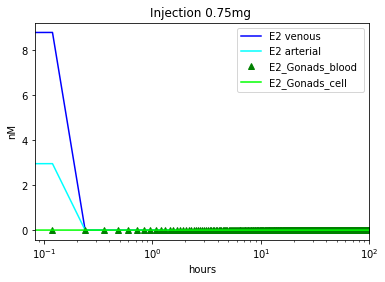

In [50]:
import matplotlib.pyplot as plt
plt.semilogx(t,sol[:,0],'b', label='E2 venous')
plt.semilogx(t,sol[:,5],'cyan', label='E2 arterial')
plt.semilogx(t,sol[:,13],'g^',label = 'E2_Gonads_blood ')
plt.semilogx(t,sol[:,14],'lime',label = 'E2_Gonads_cell')
plt.title('Injection 0.75mg ')
plt.legend(loc='best')
plt.xlim(-5,100)
plt.xlabel('hours')
plt.ylabel('nM')

In [0]:
y=np.zeros(34)
# SHBG: for female 80nM
y[1] = 80
y[6] = 80
y[3] = 500000   #albumin
y[8] = 500000  #albumin
y[15] =  0.091        #ER_Gonads_cells
y[22] =  1.4   #ER_Liver_cells
y[32] = 500  # oral dose
y[33] = 0  # injection dose
y[28] = 0 #skin c0
t = np.linspace(0, 240, num = 2000 )
sol = odeint(func, y, t)

Text(0, 0.5, 'nM')

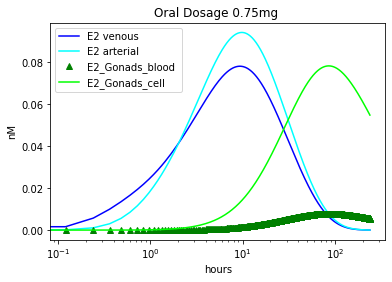

In [52]:
import matplotlib.pyplot as plt
plt.semilogx(t,sol[:,0],'b', label='E2 venous')
plt.semilogx(t,sol[:,5],'cyan', label='E2 arterial')
plt.semilogx(t,sol[:,13],'g^',label = 'E2_Gonads_blood ')
plt.semilogx(t,sol[:,14],'lime',label = 'E2_Gonads_cell')
plt.title('Oral Dosage 0.75mg ')
plt.legend(loc='best')
plt.xlabel('hours')
plt.ylabel('nM')

In [0]:
y=np.zeros(34)
# SHBG: for female 80nM
y[1] = 80
y[6] = 80
y[3] = 500000   #albumin
y[8] = 500000  #albumin
y[15] =  0.091        #ER_Gonads_cells
y[22] =  1.4   #ER_Liver_cells
y[32] = 0  # oral dose
y[33] = 0  # injection dose
y[28] = 384 #skin c0 = 500*2/2.6
t = np.linspace(0, 240, num = 3000 )
sol = odeint(func, y, t)

Text(0, 0.5, 'nM')

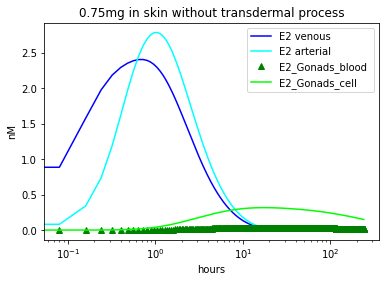

In [54]:
import matplotlib.pyplot as plt
plt.semilogx(t,sol[:,0],'b', label='E2 venous')
plt.semilogx(t,sol[:,5],'cyan', label='E2 arterial')
plt.semilogx(t,sol[:,13],'g^',label = 'E2_Gonads_blood ')
plt.semilogx(t,sol[:,14],'lime',label = 'E2_Gonads_cell')
plt.title('0.75mg in skin without transdermal process')
plt.legend(loc='best')
plt.xlabel('hours')
plt.ylabel('nM')